<a href="https://colab.research.google.com/github/RVasconcelosMiguel/ComputerVision/blob/main/C%C3%B3pia_de_CV_Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [269]:
pip install tqdm

In [270]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm  # Importar tqdm

import os
import pandas as pd
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.autograd import Variable
from torch.optim import Adam, SGD, NAdam
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler


import torchvision
from torchvision import models, transforms
from torchvision.io import read_image

from torchsummary import summary

import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm  # Importar tqdm

import os
import pandas as pd
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.autograd import Variable
from torch.optim import Adam, SGD, NAdam
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler


import torchvision
from torchvision import models, transforms
from torchvision.io import read_image

from torchsummary import summary

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from PIL import Image
import zipfile


from PIL import Image
import zipfile

In [271]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")

The model will be running on cuda:0 device


In [272]:
# Clear existing files or directories from previous runs
!rm -f -r "/content/images"
!rm -f "/content/module_metadata.json"

# Define paths for download and extraction
repo_path = "/content/InfraredSolarModules/"
zip_path = "/content/2020-02-14_InfraredSolarModules.zip"
extract_path = "/content"

# Clone the repository and extract the zip file
!git clone https://github.com/RaptorMaps/InfraredSolarModules.git $repo_path
!mv "$repo_path/2020-02-14_InfraredSolarModules.zip" $extract_path
!unzip -uq $zip_path -d $extract_path

# Move images folder to the root directory
image_folder_path = "/content/InfraredSolarModules/images"
!mv $image_folder_path $extract_path

# Move module_metadata.json to the root directory
metadata_file_path = "/content/InfraredSolarModules/module_metadata.json"
!mv $metadata_file_path $extract_path

# Verify the final structure
!ls /content


fatal: destination path '/content/InfraredSolarModules' already exists and is not an empty directory.
mv: cannot stat '/content/InfraredSolarModules//2020-02-14_InfraredSolarModules.zip': No such file or directory
2020-02-14_InfraredSolarModules.zip  InfraredSolarModules  module_metadata.json  sample_data
images				     __MACOSX		   myModel_best_A.pth


In [273]:
# Path to metadata JSON file
metadata_path = '/content/module_metadata.json'

# Load metadata
with open(metadata_path, 'r') as f:
    metadata = json.load(f)

# Convert metadata to DataFrame
df = pd.DataFrame.from_dict(metadata, orient='index')

# Binary Classification DataFrame
df_binary = df.copy()
df_binary['anomaly_class'] = df_binary['anomaly_class'].apply(
    lambda x: 1 if x.lower() != 'no-anomaly' else 0
)

# Display DataFrame details
print("*************** Binary Classification DataFrame ***************")
print(df_binary.head())
print("Total rows:", df_binary.shape[0])

train_ratio = 0.90
test_ratio = 0.10
train_data, test_data = train_test_split(df_binary, test_size=test_ratio, train_size=train_ratio, random_state=2, stratify=df_binary['anomaly_class'])

train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)


*************** Binary Classification DataFrame ***************
         image_filepath  anomaly_class
13357  images/13357.jpg              0
13356  images/13356.jpg              0
19719  images/19719.jpg              0
11542  images/11542.jpg              0
11543  images/11543.jpg              0
Total rows: 20000


In [274]:
"""
train_data, test_data=train_test_split(df_binary, test_size=0.15,train_size=0.85, random_state=2, stratify=df_binary["anomaly_class"])
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)
"""



'\ntrain_data, test_data=train_test_split(df_binary, test_size=0.15,train_size=0.85, random_state=2, stratify=df_binary["anomaly_class"])\ntrain_data.reset_index(drop=True, inplace=True)\ntest_data.reset_index(drop=True, inplace=True)\n'

ESTÁ IGUAL AO DO VITOR TEMOS QUE MUDAR DAQUI PARA BAIXO

In [275]:
class MyImageDataset(data.Dataset):
    def __init__(self, metadata, transform=None, img_mode="L"):

        self.img_labels = metadata["anomaly_class"].values
        self.img_paths = metadata["image_filepath"].values
        self.transform = transform
        self.img_mode = img_mode

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):

        try:
            img_path = self.img_paths[idx]

            # Ensure the image file exists
            if not os.path.exists(img_path):
                raise FileNotFoundError(f"Image file not found: {img_path}")

            # Open and convert the image
            image = Image.open(img_path).convert(self.img_mode)
            label = self.img_labels[idx]

            # Apply transformations if specified
            if self.transform:
                image = self.transform(image)

            return image, torch.tensor(label, dtype=torch.long)

        except Exception as e:
            raise RuntimeError(f"Error loading sample at index {idx}: {e}")

"""
class MyImageDataset(data.Dataset):
    def __init__(self, metadata, transform=None):
        self.img_labels = metadata["anomaly_class"].values
        self.img_paths = metadata["image_filepath"].values
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):#posteriormente o dataloader vai passar por todos os idx
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert("L") # Abrir a imagem como RGB
        label = self.img_labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)
"""


'\nclass MyImageDataset(data.Dataset):\n    def __init__(self, metadata, transform=None):\n        self.img_labels = metadata["anomaly_class"].values\n        self.img_paths = metadata["image_filepath"].values\n        self.transform = transform\n\n    def __len__(self):\n        return len(self.img_labels)\n\n    def __getitem__(self, idx):#posteriormente o dataloader vai passar por todos os idx\n        img_path = self.img_paths[idx]\n        image = Image.open(img_path).convert("L") # Abrir a imagem como RGB\n        label = self.img_labels[idx]\n\n        if self.transform:\n            image = self.transform(image)\n\n        return image, torch.tensor(label, dtype=torch.long)\n'

In [276]:
# Transformações
transform = transforms.Compose([

    transforms.ToTensor(),  # Converte para tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normaliza
])

# Datasets
train_dataset = MyImageDataset(metadata=train_data, transform=transform)
test_dataset = MyImageDataset(metadata=test_data, transform=transform)

# DataLoaders
batch_size = 16
train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)



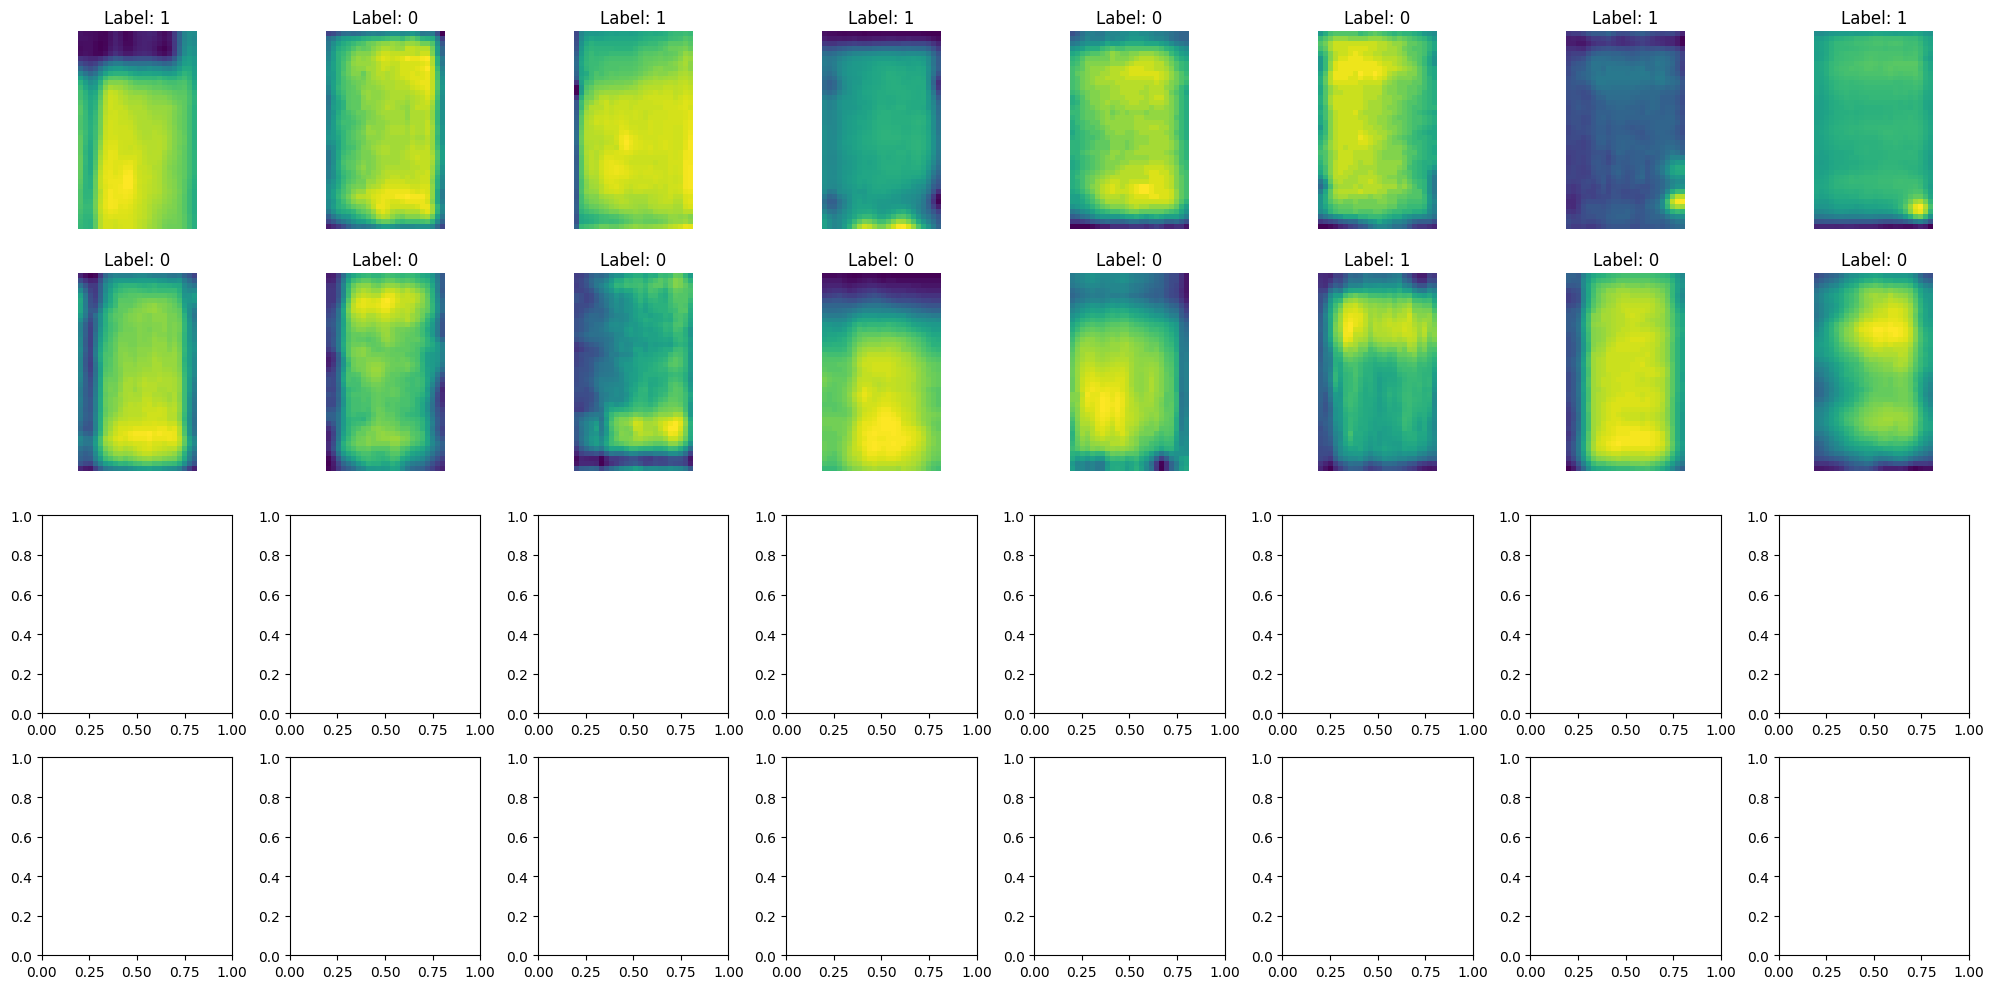

In [277]:
# Obtém um batch de imagens, seus rótulos e os caminhos
images, labels = next(iter(train_loader))  # Pega o primeiro batch

# Desfazendo a normalização para as imagens
images = images * 0.5 + 0.5  # Inverte a normalização, para voltar ao intervalo [0, 1]

# Cria uma figura com múltiplos subplots
fig, axes = plt.subplots(4, 8, figsize=(20, 10))  # 4 linhas e 8 colunas
axes = axes.flatten()  # Para facilitar o acesso aos eixos (axes)

# Loop para exibir as 32 primeiras imagens do batch
for i in range(len(images)):
    image = images[i]  # Pega a i-ésima imagem do batch
    image_pil = transforms.ToPILImage()(image)  # Converte o tensor para uma imagem PIL

    # Exibe a imagem
    axes[i].imshow(image_pil)
    axes[i].set_title(f"Label: {labels[i].item()}")  # Exibe o rótulo e o caminho do arquivo
    axes[i].axis('off')  # Remove os eixos para uma exibição mais limpa

plt.tight_layout()  # Ajusta o layout para que as imagens não se sobreponham
plt.show()







In [278]:

#Mesmo da prática
class Network(nn.Module):
    def __init__(self):
        super().__init__()

        # Camadas convolucionais e de pooling
        self.conv1 = nn.Conv2d(1, 64, 5)  # Tem de ser assim o 1 e
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 5)  # Tamanho esperado: [128, 18, 34] (kernel 3x3)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(2, 2)  # Tamanho esperado após pool1: [128, 9, 17] (redução pelo max pool)
        self.conv3 = nn.Conv2d(128, 256, 3)  # Tamanho esperado: [256, 7, 15] (kernel 3x3)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, 3)  # Tamanho esperado: [512, 5, 13] (kernel 3x3)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool2 = nn.MaxPool2d(2, 2)  # Tamanho esperado após pool2: [512, 2, 6] (redução pelo max pool)

        # Calculando a entrada correta para a camada fully connected (Linear)
        self.fc1 = nn.Linear(512 * 2 * 6, 1024)  # O valor de 512*2*6 vem das dimensões finais após a convolução
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 512)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(512, 256)
        self.dropout3 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(256, 2)  # 2 saidas , deixar o 2 pq sao apenas duas saidas mas nos restantes é 11 e 12

    def forward(self, x):
        # Passa pela primeira camada convolucional, ReLU, e pooling
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(F.relu(self.bn2(self.conv2(x))))

        # Passa pela segunda camada convolucional, ReLU e pooling
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool2(F.relu(self.bn4(self.conv4(x))))


        # Achata a saída para a camada Linear
        x = torch.flatten(x, 1)  # Achata para [batch_size, 512*2*6]

        # Passa pelas camadas Fully Connected e Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)
        x = self.fc4(x)

        return x

model = Network()
# Define the loss function
loss_fn = nn.CrossEntropyLoss().to(device)

learn_rate_optimizer=0.002         # entre 0.002 e 0.0025
momentum_optimizer=0.95     # entre 0.9 e 0.95
weight_decay_optimizer=1e-4 # Added weight decay to prevent overfitting
nesterov_optimizer=True
# Define the optimizer
optimizer = SGD(model.parameters(), lr=learn_rate_optimizer, momentum=momentum_optimizer, weight_decay=weight_decay_optimizer, nesterov=nesterov_optimizer)
#optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4, nesterov=True

In [279]:
from torch.autograd import Variable

# Function to save the model
def saveModel(model:nn.Module, path):
    torch.save(model.state_dict(), path)

# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(model: torch.nn.Module,
          dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          device: torch.device,
          num_epochs,
          path_model,
          verbatim):
    model.train()
    model.to(device)
    best_accuracy = 0.0
    best_loss = 0.0
    best_epoch = 0
    for epoch in tqdm(range(num_epochs), desc="Epochs", unit="epoch"):  # Adicionando a barra de progresso para os epochs

        train_acc = 0.0
        train_loss = 0.0
        for ibatch, (images, labels) in enumerate(dataloader):  # Adicionando a barra de progresso para os batches

            # get the inputs
            images = images.to(device)
            labels = labels.to(device)

            # 1. Forward pass
            y_pred = model(images)
            y_pred = y_pred.squeeze(dim=1)

            # 2. Calculate  and accumulate loss
            loss = loss_fn(y_pred, labels)
            train_loss += loss.item()

            # 3. Optimizer zero grad
            optimizer.zero_grad()

            # 4. Loss backward
            loss.backward()

            # 5. Optimizer step
            optimizer.step()

            # Calculate and accumulate accuracy metric across all batches
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            train_acc += (y_pred_class == labels).sum().item()/len(y_pred)

        # Adjust metrics to get average loss and accuracy per batch
        train_loss = train_loss / len(dataloader)
        train_acc = train_acc / len(dataloader)

        # we want to save the model if the accuracy is the best


        if train_acc > best_accuracy:
            path = str(path_model)
            saveModel(model, path = path)
            best_loss = train_loss
            best_accuracy = train_acc
            best_epoch = epoch
            if verbatim:
              print('Best Epoch #', epoch,' Loss=', best_loss, " Accu=", best_accuracy )

    return best_loss, best_accuracy, best_epoch

In [280]:
# Function to test the model with the test dataset and print the accuracy for the test images
def test(model: torch.nn.Module,
         dataloader: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module,
         device: torch.device,
         verbatim = True):

    # Put model in eval mode
    model.eval()
    model.to(device)
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    pred_labels = []
    with torch.no_grad():
        for data in dataloader:

            # get the inputs
            images, labels = data
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            # 1. run the model on the test set to predict labels
            y_pred = model(images)

            # 2. Calculate and accumulate loss
            loss = loss_fn(y_pred, labels)
            test_loss += loss.item()

            # 3. Calculate and accumulate accuracy
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            test_acc += (y_pred_class == labels).sum().item()/len(y_pred)
            pred_labels = y_pred_class.tolist()

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    if verbatim:
      print("Loss =", test_loss, "  Accuracy=", test_acc)
    return pred_labels, test_loss, test_acc


In [ ]:
if __name__ == "__main__":

    model = model.to(device)

    # Build our model
    best_loss, best_accuracy, best_epoch = train(model=model,
                                                    dataloader=train_loader,
                                                    loss_fn=loss_fn,
                                                    optimizer=optimizer,
                                                    device=device,
                                                    num_epochs = 40,
                                                    path_model = str("./myModel_best_A.pth"),
                                                    verbatim = True)

Epochs:   2%|▎         | 1/40 [00:24<16:09, 24.87s/epoch]

Best Epoch # 0  Loss= 0.49492013951142627  Accu= 0.7605


Epochs:   5%|▌         | 2/40 [00:43<13:15, 20.94s/epoch]

Best Epoch # 1  Loss= 0.402218248989847  Accu= 0.8215


Epochs:   8%|▊         | 3/40 [01:00<11:55, 19.34s/epoch]

Best Epoch # 2  Loss= 0.35527696279353566  Accu= 0.8518888888888889


Epochs:  10%|█         | 4/40 [01:19<11:33, 19.27s/epoch]

Best Epoch # 3  Loss= 0.3263836988972293  Accu= 0.8665


Epochs:  12%|█▎        | 5/40 [01:37<10:53, 18.69s/epoch]

Best Epoch # 4  Loss= 0.30398523313469356  Accu= 0.8773888888888889


Epochs:  15%|█▌        | 6/40 [01:54<10:20, 18.25s/epoch]

Best Epoch # 5  Loss= 0.28099336767196653  Accu= 0.8853333333333333


Epochs:  18%|█▊        | 7/40 [02:12<09:52, 17.97s/epoch]

Best Epoch # 6  Loss= 0.2658045401374499  Accu= 0.8944444444444445


Epochs:  20%|██        | 8/40 [02:30<09:37, 18.06s/epoch]

Best Epoch # 7  Loss= 0.25326800626185203  Accu= 0.9023888888888889


Epochs:  22%|██▎       | 9/40 [02:48<09:18, 18.03s/epoch]

Best Epoch # 8  Loss= 0.24419861505346166  Accu= 0.9068888888888889


Epochs:  25%|██▌       | 10/40 [03:05<08:57, 17.92s/epoch]

Best Epoch # 9  Loss= 0.2334904959383938  Accu= 0.9097222222222222


Epochs:  28%|██▊       | 11/40 [03:23<08:36, 17.82s/epoch]

Best Epoch # 10  Loss= 0.21777641630255515  Accu= 0.9149444444444444


Epochs:  30%|███       | 12/40 [03:41<08:20, 17.88s/epoch]

Best Epoch # 11  Loss= 0.20924313942674133  Accu= 0.9215


Epochs:  32%|███▎      | 13/40 [03:59<08:02, 17.86s/epoch]

Best Epoch # 12  Loss= 0.19847127604236206  Accu= 0.9243333333333333


Epochs:  35%|███▌      | 14/40 [04:16<07:41, 17.75s/epoch]

Best Epoch # 13  Loss= 0.18725849305010503  Accu= 0.9256111111111112


Epochs:  38%|███▊      | 15/40 [04:34<07:22, 17.68s/epoch]

Best Epoch # 14  Loss= 0.18008947041299608  Accu= 0.9313888888888889


Epochs:  40%|████      | 16/40 [04:52<07:05, 17.73s/epoch]

Best Epoch # 15  Loss= 0.1787523704485761  Accu= 0.9336111111111111


Epochs:  42%|████▎     | 17/40 [05:10<06:48, 17.77s/epoch]

Best Epoch # 16  Loss= 0.1670684134103358  Accu= 0.9376111111111111


Epochs:  45%|████▌     | 18/40 [05:27<06:29, 17.69s/epoch]

Best Epoch # 17  Loss= 0.15900825694410337  Accu= 0.9427222222222222


Epochs:  48%|████▊     | 19/40 [05:45<06:09, 17.59s/epoch]

Best Epoch # 18  Loss= 0.15227259056477083  Accu= 0.9448888888888889


Epochs:  52%|█████▎    | 21/40 [06:22<05:43, 18.10s/epoch]

Best Epoch # 20  Loss= 0.1421765987359815  Accu= 0.9458333333333333


Epochs:  55%|█████▌    | 22/40 [06:39<05:23, 17.99s/epoch]

Best Epoch # 21  Loss= 0.13324544196244742  Accu= 0.9515555555555556


In [ ]:
y_pred, test_loss, test_acc  = test(model=model,
                                    dataloader=test_loader,
                                    loss_fn=loss_fn,
                                    device=device,
                                    verbatim = True)